# Thuật toán 4: Rừng ngẫu nhiên (Random Forest)

**Mục tiêu:** Xây dựng một mô hình ensemble để cải thiện độ chính xác và giải quyết vấn đề overfitting của một Cây quyết định đơn lẻ.

**Logic thuật toán:** Random Forest là một phương pháp học tập "ensemble" (tập hợp). Nó xây dựng nhiều Cây quyết định (hàng trăm hoặc hàng nghìn cây) trong quá trình huấn luyện. Để dự đoán, mỗi cây trong "khu rừng" sẽ đưa ra một phiếu bầu (vote), và kết quả cuối cùng là phiếu bầu được đa số cây lựa chọn. 

Nó chống overfitting bằng 2 kỹ thuật chính:
1.  **Bagging (Bootstrap Aggregating):** Mỗi cây được huấn luyện trên một mẫu *con* ngẫu nhiên (lấy có lặp lại) từ tập dữ liệu huấn luyện.
2.  **Feature Randomness:** Tại mỗi nút (node) của cây, thay vì xem xét *tất cả* các đặc trưng, cây chỉ được phép chọn ngẫu nhiên một *tập con* các đặc trưng (ví dụ: `sqrt(tổng số đặc trưng)`) để tìm ra phép chia tốt nhất. 

**Các bước thực hiện:**
1.  **Giai đoạn 1: Tải và Tiền xử lý Dữ liệu:** Tái sử dụng quy trình giống của Decision Tree(One-Hot Encoding, **không Scaling**).
2.  **Giai đoạn 2: Xây dựng Mô hình (Cơ bản):** Huấn luyện mô hình Random Forest với các tham số mặc định (100 cây).
3.  **Giai đoạn 3: Đánh giá Mô hình (Cơ bản):** Đánh giá hiệu suất. Chúng ta sẽ thấy overfitting giảm đi đáng kể so với Decision Tree.
4.  **Giai đoạn 4: Tinh chỉnh Hyperparameter (Phần chính):** Dùng `GridSearchCV` để tìm tổ hợp tham số tốt nhất.
5.  **Giai đoạn 5: Kết luận & Phân tích:** Đánh giá mô hình cuối cùng và trích xuất Feature Importance (thường sẽ đáng tin cậy hơn so với một cây đơn lẻ).

## Giai đoạn 1: Tải và Tiền xử lý Dữ liệu

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Tải dữ liệu
data = pd.read_csv('heart.csv')

# Xóa các hàng trùng lặp
print(f"Số hàng ban đầu: {len(data)}")
data = data.drop_duplicates()
print(f"Số hàng sau khi xóa trùng lặp: {len(data)}")

# Tách X(features) và y(target)
X = data.drop('HeartDisease', axis=1)
Y = data["HeartDisease"]

# 1. Biến Categorical: One-hot Encoding
categorical_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# 2. Biến Numerical: Không cần scaling:
# Decision Tree không dựa trên khoảng cách nên không cần StandardScaler.
# Bỏ qua bước này giúp chúng ta diễn giải cây dễ dàng hơn (ví dụ: 'Age > 50' thay vì 'Age > 0.5')
print("Đã bỏ qua StandardScaler một cách có chủ đích.")

print(f"Tập huấn luyện: {X_train.shape}\nTập kiểm tra: {X_test.shape}")

Số hàng ban đầu: 918
Số hàng sau khi xóa trùng lặp: 918
Đã bỏ qua StandardScaler một cách có chủ đích.
Tập huấn luyện: (734, 15)
Tập kiểm tra: (184, 15)


## Giai đoạn 2: Xây dựng Mô hình cơ bản

Chúng ta sẽ huấn luyện một khu rừng với 100 cây (tham số mặc định `n_estimators=100`).

In [5]:
# Khởi tạo mô hình với các tham số mặc định
model_rf_default = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

# Huấn luyện mô hình
model_rf_default.fit(X_train, Y_train)

print("Mô hình Random Forest (mặc định) đã được huấn luyện.")

Mô hình Random Forest (mặc định) đã được huấn luyện.


## Giai đoạn 3: Đánh giá Mô hình cơ bản

Khi so sánh điểm train và test. Ta có thể thấy điểm train không còn là 100% nữa, và điểm test thường sẽ cao hơn mô hình Decision Tree mặc định.

--- Điểm trên Tập Huấn luyện (Train) ---
F1-Score (Train): 1.0000

--- Điểm trên Tập Kiểm thử (Test) ---
Accuracy: 0.8750
Precision: 0.8962
Recall: 0.8879
F1-Score (Test): 0.8920


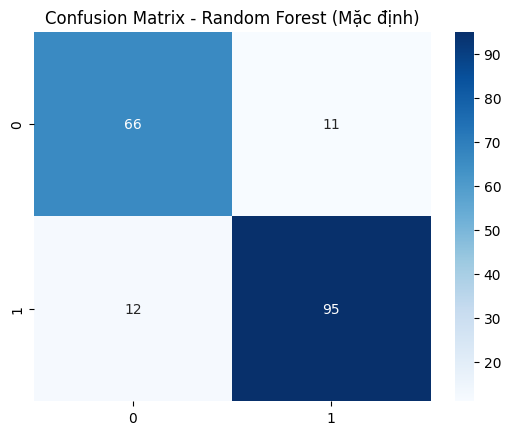

In [6]:
# Đánh giá trên tập Train
Y_pred_train = model_rf_default.predict(X_train)
f1_train = f1_score(Y_train, Y_pred_train)
print(f"--- Điểm trên Tập Huấn luyện (Train) ---")
print(f"F1-Score (Train): {f1_train:.4f}")

# Đánh giá trên tập Test
Y_pred_test = model_rf_default.predict(X_test)
f1_test = f1_score(Y_test, Y_pred_test)
print(f"\n--- Điểm trên Tập Kiểm thử (Test) ---")
print(f"Accuracy: {accuracy_score(Y_test, Y_pred_test):.4f}")
print(f"Precision: {precision_score(Y_test, Y_pred_test):.4f}")
print(f"Recall: {recall_score(Y_test, Y_pred_test):.4f}")
print(f"F1-Score (Test): {f1_test:.4f}")

# Ma trận nhầm lẫn
cm = confusion_matrix(Y_test, Y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest (Mặc định)')
plt.show()

**Nhận xét:**
`F1-Score` trên tập **Train** của Random Forest vẫn là `1.0000`, tuy nhiên `F1-Score` trên tập **Test** lại cao hơn `0.8920 > 0.8756` nên có thể thấy Random Forest **tổng quan hóa tốt hơn** và **ít bị overfitting hơn**.

## Giai đoạn 4: Tinh chỉnh Hyperparameter

**Logic:**
Khi tinnh chỉnh Random Forest, chúng ta cần tìm số lượng cây (`n_estimators`) vừa đủ, và các tham số cắt tỉa (`max_depth`, `min_samples_leaf`) để ngăn các cây con bị overfit.

**Các siêu tham số (Hyperparameters) chính:**
* `n_estimators`: Số lượng cây trong rừng. (Thường chọn 100, 200, 300...)
* `max_depth`: Độ sâu tối đa của mỗi cây. (Tương tự Decision Tree)
* `min_samples_leaf`: Số mẫu tối thiểu ở mỗi lá. (Tương tự Decision Tree)
* `max_features`: Số lượng đặc trưng tối đa được xem xét tại mỗi lần chia. ('sqrt' là mặc định, 'log2', hoặc số cụ thể).


In [7]:
# 2. Tinh chỉnh (GridSearchCV)
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 8, 10, None],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Khởi tạo GridSearchCV (tối ưu theo Recall)
grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=param_grid_rf,
    scoring='recall',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Chạy GridSearch trên tập huấn luyện
print("Bắt đầu GridSearchCV cho Random Forest...")
grid_search_rf.fit(X_train, Y_train)

# In ra các tham số tốt nhất
print(f"\nBest Hyperparameters: {grid_search_rf.best_params_}")
print (f"Best Recall from GridSearchCV: {grid_search_rf.best_score_:.4f}")

Bắt đầu GridSearchCV cho Random Forest...
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Best Hyperparameters: {'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 300}
Best Recall from GridSearchCV: 0.9227


## Giai đoạn 5: Đánh giá Mô hình Tinh chỉnh & Phân tích


--- Kết quả đánh giá Random Forest sau khi Tuning ---
Accuracy: 0.8641
Precision: 0.8868
Recall: 0.8785
F1-Score: 0.8826


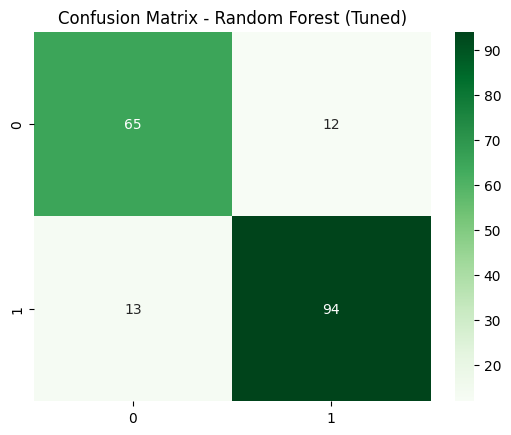

In [8]:
# Lấy mô hình tốt nhất
best_model_rf = grid_search_rf.best_estimator_

# Đánh giá trên tập Test
Y_pred_best = best_model_rf.predict(X_test)

print("\n--- Kết quả đánh giá Random Forest sau khi Tuning ---")
print(f"Accuracy: {accuracy_score(Y_test, Y_pred_best):.4f}")
print(f"Precision: {precision_score(Y_test, Y_pred_best):.4f}")
print(f"Recall: {recall_score(Y_test, Y_pred_best):.4f}")
print(f"F1-Score: {f1_score(Y_test, Y_pred_best):.4f}")

# Ma trận nhầm lẫn sau khi tuning
cm_best = confusion_matrix(Y_test, Y_pred_best)
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Random Forest (Tuned)')
plt.show()